# Synoptic State Snapshots

This notebook randomly selects 4 timesteps from each season and plots their synoptic states on top of the composite state for that season.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
import numpy as np
import glob
import cartopy

In [2]:
# set the file paths for each season
seasons = ['DJF', 'MAM', 'JJA', 'SON']

path_template = "era5_bloomington_ar_teca_bard_v1.0.1/lag_+000/era5_bloomington_ar_teca_bard_v1.0.1_annual_*-{month:02}-*-00Z_*.nc"

paths = {}
paths['DJF'] = sorted(glob.glob(path_template.format(month=12)) + glob.glob(path_template.format(month=1)) + glob.glob(path_template.format(month=2)))
paths['MAM'] = sorted(glob.glob(path_template.format(month=3)) + glob.glob(path_template.format(month=4)) + glob.glob(path_template.format(month=5)))
paths['JJA'] = sorted(glob.glob(path_template.format(month=6)) + glob.glob(path_template.format(month=7)) + glob.glob(path_template.format(month=8)))
paths['SON'] = sorted(glob.glob(path_template.format(month=9)) + glob.glob(path_template.format(month=10)) + glob.glob(path_template.format(month=11)))

# randomly select 4 paths from each season
nsel = 5
random_paths = {}
np.random.seed(0) # set a seed for reproducibility
for season in seasons:
    random_paths[season] = np.random.choice(paths[season], nsel)

# also set the composite paths for each season
composite_paths = {}
for season in seasons:
    composite_paths[season] = f"era5_bloomington_ar_teca_bard_v1.0.1/era5_bloomington_ar_teca_bard_v1.0.1_{season.lower()}_lag_+000.mean.nc"

    
# load the data
data = {s : [] for s in seasons}
for season in seasons:
    data[season] = [xr.open_dataset(composite_paths[season], chunks = -1)]
    for path in random_paths[season]:
        data[season].append(xr.open_dataset(path, chunks = -1))

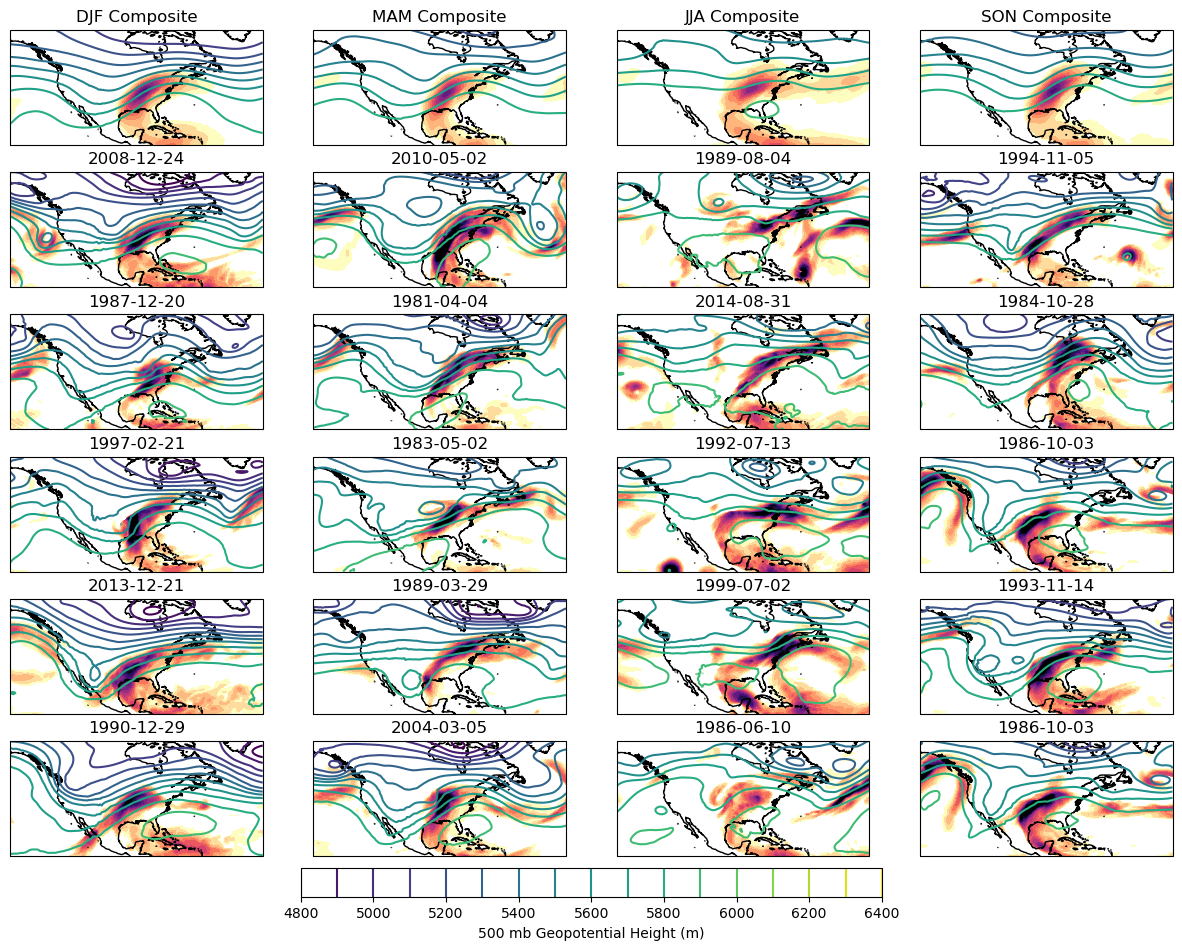

In [3]:
""" Generate a 4x5 plot of Z for each season """

fig, axs = plt.subplots(6, 4, figsize=(15, 15), subplot_kw={'projection': cartopy.crs.PlateCarree()})

for i, season in enumerate(seasons):
    for n, ds in enumerate(data[season]):
        ax = axs[n, i]
        z = ds['Z'].squeeze() / 9.81 # convert to geopotential height
        cplt = z.plot.contour(
            ax=ax,
            transform=cartopy.crs.PlateCarree(),
            levels = np.arange(4800, 6500, 100),
        )

        # pre-make the colorbar to avoid odd artefacts
        ivt_levels = np.arange(250, 1000, 50)
        ivt_cmap = 'magma_r'
        ivt = ds['IVT'].squeeze()
        ivt = ivt.where(ivt > 250)
        ivt_cplt = ivt.plot.contourf(
            ax=ax, transform=cartopy.crs.PlateCarree(),
            cmap = ivt_cmap,
            levels = ivt_levels,
            zorder = 0,
            add_colorbar = False,
        )

       
        

        ax.coastlines()

        if n == 0:
            ax.set_title(f"{season} Composite")
        else:
            # get the time from the dataset
            time = ds['time'].values[0]
            # convert the numpy datetime64 to a datetime object
            pddate = pd.to_datetime(time)
            datestr = pddate.strftime("%Y-%m-%d")
            
            ax.set_title(datestr)


# reduce vertical space between subplots
plt.subplots_adjust(hspace=-0.45)

# add a common colorbar horizontally, and bring it closer to the plots
fig.colorbar(cplt, ax=axs.ravel().tolist(), orientation='horizontal', shrink=0.5, pad=0.01, label='500 mb Geopotential Height (m)')

plt.savefig("fig_random_z500_vs_composites.pdf", bbox_inches='tight')
plt.savefig("fig_random_z500_vs_composites.png", bbox_inches='tight', dpi = 300)

plt.show()
